# Chargement des données : à adapter à votre projet !

Dans mon projet **toto**, j'ai choisi de classifier des images associées à 3 labels différents : **tata**, **titi** et **tutu**.

![Texte alternatif…](https://drive.google.com/uc?id=1J50MmxDy5yoMa1eKa2qgfnQ_Yl9Oq79y)

J'ai réparti mes images dans 3 ensembles (et donc 3 dossiers): *train* (3 images par classe), *validation* (1 image par classe) et *test* (1 image par classe). Chacun de ces dossiers comporte un sous-dossier par classe, qui contient les images correspondantes. L'arborescence est résumée sur l'image ci-dessus.

J'ai choisi d'héberger ma base de données sur Github : l'intérêt est qu'un **git clone** depuis Google Colab est très rapide, ce qui vous garantit une certaine simplicité. Je vous encourage à en faire de même.

In [10]:
# GLOBAL VARIABLES
GIT_URL = "https://github.com/chaimaeouardani/img_classification"
IMG_BASE = "./img_classification/"
CLASSES = ["hiver", "printemps", "ete", "automne"]


In [2]:
!git clone $GIT_URL

Cloning into 'img_classification'...
remote: Enumerating objects: 4320, done.
remote: Counting objects: 100% (4320/4320), done.
remote: Compressing objects: 100% (4300/4300), done.
remote: Total 4320 (delta 16), reused 4316 (delta 12), pack-reused 0
Receiving objects: 100% (4320/4320), 398.16 MiB | 38.26 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Checking out files: 100% (4713/4713), done.


Une fois les données téléchargées localement, on peut maintenant charger les images et les labels. Si vous avez construit votre arborescence de la même manière que la mienne, et que vous adaptez les noms de labels à votre projet, alors le code suivant devrait être utilisable directement.

In [16]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat

def load_data(data_path, classes, dataset='train', image_size=64):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    print(f"Found {num_images}.")

    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        print(f"Processing class \"{classes[idx_class]}\":")
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            print(f"\r\033[K- Processing image {idx_img+1}/{len(dirs)}", end = "")
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = img.resize((image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1

        print(f"\r\033[KFinished processing {classes[idx_class]}")

    return x, y

Voici ensuite un exemple de chargement de vos données. Notez que vous pouvez modifier la dimension des images, ce qui sera utile à différents stades de votre projet.

In [17]:
labels = CLASSES

x_train, y_train = load_data(IMG_BASE, labels, dataset='train', image_size=64)
print(x_train.shape, y_train.shape)

x_val, y_val = load_data(IMG_BASE, labels, dataset='validation', image_size=64)
print(x_val.shape, y_val.shape)

x_test, y_test = load_data(IMG_BASE, labels, dataset='test', image_size=64)
print(x_test.shape, y_test.shape)

Found 4703.
Processing class "hiver":

Finished processing hiver
Processing class "printemps":

Finished processing printemps
Processing class "ete":

Finished processing ete
Processing class "automne":

Finished processing automne
(4703, 64, 64, 3) (4703, 1)
Found 4.
Processing class "hiver":

Finished processing hiver
Processing class "printemps":

Finished processing printemps
Processing class "ete":

Finished processing ete
Processing class "automne":

Finished processing automne
(4, 64, 64, 3) (4, 1)
Found 4.
Processing class "hiver":

Finished processing hiver
Processing class "printemps":

Finished processing printemps
Processing class "ete":

Finished processing ete
Processing class "automne":

Finished processing automne
(4, 64, 64, 3) (4, 1)


Vous pouvez utiliser le bloc suivant pour afficher quelques-unes de vos images, et ainsi vérifier que tout s'est bien passé.

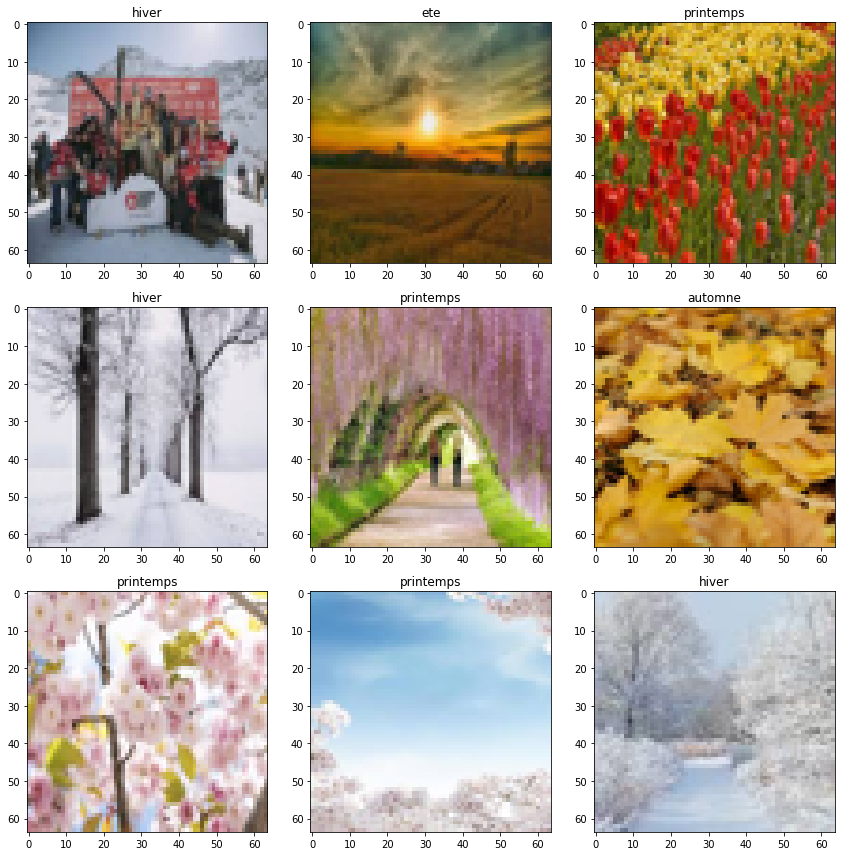

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(y_train.shape[0])
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()